In [1]:
# Import necessary libraries
import pandas as pd

# File paths
u_data_path = 'data/raw/u.data'
u_genre_path = 'data/raw/u.genre'
u_item_path = 'data/raw/u.item'
u_occupation_path = 'data/raw/u.occupation'
u_user_path = 'data/raw/u.user'

# Load data
u_data = pd.read_csv(u_data_path, sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
u_genre = pd.read_csv(u_genre_path, sep='|', names=['genre', 'genre_id'])
u_item = pd.read_csv(u_item_path, sep='|', encoding='latin-1', names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'], header=None)
u_occupation = pd.read_csv(u_occupation_path, names=['occupation'])
u_user = pd.read_csv(u_user_path, sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

# Display first few rows of each data file
(u_data.head(), u_genre.head(), u_item.head(), u_occupation.head(), u_user.head())


(   user_id  item_id  rating  timestamp
 0      196      242       3  881250949
 1      186      302       3  891717742
 2       22      377       1  878887116
 3      244       51       2  880606923
 4      166      346       1  886397596,
         genre  genre_id
 0     unknown         0
 1      Action         1
 2   Adventure         2
 3   Animation         3
 4  Children's         4,
    movie_id        movie_title release_date  video_release_date  \
 0         1   Toy Story (1995)  01-Jan-1995                 NaN   
 1         2   GoldenEye (1995)  01-Jan-1995                 NaN   
 2         3  Four Rooms (1995)  01-Jan-1995                 NaN   
 3         4  Get Shorty (1995)  01-Jan-1995                 NaN   
 4         5     Copycat (1995)  01-Jan-1995                 NaN   
 
                                             IMDb_URL  unknown  Action  \
 0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
 1  http://us.imdb.com/M/title-exact?GoldenEye%20(

u.data:

Contains 100,000 ratings (1-5) from 943 users on 1682 movies.
Columns: user_id, item_id, rating, timestamp.
u.genre:

Contains a list of movie genres.
Columns: genre, genre_id.
u.item:

Contains information about the movies.
Columns: movie_id, movie_title, release_date, video_release_date, IMDb_URL, followed by columns for each genre (1 indicates the movie is of that genre, 0 indicates it is not).
u.occupation:

Contains a list of occupations.
u.user:

Contains demographic information about the users.
Columns: user_id, age, gender, occupation, zip_code.

Now, let's proceed to build the movie recommendation system based on network analysis. The steps to build the recommendation system are as follows:

Create a bipartite graph with users and movies as two sets of nodes.
Add edges between users and movies they have rated.
For each movie, find its similarity with other movies based on common users who have rated both movies.
Recommend movies to a user based on the similarity scores of movies they have rated.
Let's start by creating the bipartite graph.​

In [2]:
# Import necessary libraries for network analysis
import networkx as nx

# Create a bipartite graph
B = nx.Graph()

# Add nodes for users and movies
B.add_nodes_from(u_data['user_id'], bipartite=0)  # Add user nodes with bipartite attribute 0
B.add_nodes_from(u_data['item_id'], bipartite=1)  # Add movie nodes with bipartite attribute 1

# Add edges between users and movies with ratings as edge weights
for row in u_data.itertuples():
    B.add_edge(row.user_id, row.item_id, weight=row.rating)

# Verify the graph creation
B.number_of_nodes(), B.number_of_edges()

(1682, 94928)

The bipartite graph has been created with 
1682
1682 nodes (representing both users and movies) and 
94928
94928 edges (representing user ratings for movies). Each edge has a weight corresponding to the user's rating for the movie.

Next, we will proceed with finding the similarity between movies based on common users who have rated both movies. We will use the Jaccard similarity coefficient for this purpose. The Jaccard similarity between two movies is defined as the number of common users who have rated both movies divided by the total number of unique users who have rated either of the two movies. Mathematically, the Jaccard similarity between movies $A$ and $B$ is given by:


Let's calculate the Jaccard similarity between each pair of movies.​

In [3]:
from itertools import combinations

# Function to compute Jaccard similarity between two sets
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Get the sets of users who have rated each movie
movie_users = {movie: set(users) for movie, users in u_data.groupby('item_id')['user_id']}

# Compute Jaccard similarity between each pair of movies
movie_similarity = {}
for movie1, movie2 in combinations(movie_users.keys(), 2):
    similarity = jaccard_similarity(movie_users[movie1], movie_users[movie2])
    movie_similarity[(movie1, movie2)] = similarity

# Display first 5 movie similarity pairs
list(movie_similarity.items())[:5]

[((1, 2), 0.21711899791231734),
 ((1, 3), 0.16810344827586207),
 ((1, 4), 0.291015625),
 ((1, 5), 0.11850311850311851),
 ((1, 6), 0.03017241379310345)]

The Jaccard similarity between each pair of movies has been successfully calculated. Here are the similarity scores for the first five movie pairs:

Movie 1 and Movie 2: 
0.217

Movie 1 and Movie 3: 
0.168

Movie 1 and Movie 4: 
0.291

Movie 1 and Movie 5: 
0.119

Movie 1 and Movie 6: 
0.030

Next, we will proceed with recommending movies to a user based on the similarity scores of movies they have rated. To do this, we will follow these steps:

For a given user, retrieve the list of movies they have rated.
For each movie the user has rated, find its similarity with other movies based on the Jaccard similarity scores.
Compute a weighted average of the similarity scores, with the user's ratings as weights.
Recommend movies with the highest weighted average scores.
Let's implement the recommendation function.​

In [7]:
# Function to recommend movies to a user based on Jaccard similarity
def recommend_movies(user_id, num_recommendations=5):
    # Get the list of movies rated by the user
    user_movies = u_data[u_data['user_id'] == user_id]
    
    # Initialize a dictionary to store the weighted average scores for each movie
    weighted_scores = {}
    
    # For each movie rated by the user
    for row in user_movies.itertuples():
        movie1 = row.item_id
        rating1 = row.rating
        
        # For each other movie
        for movie2 in movie_users.keys():
            if movie1 != movie2:
                # Get the Jaccard similarity between the two movies
                similarity = movie_similarity.get((min(movie1, movie2), max(movie1, movie2)), 0)
                
                # Compute the weighted average score for movie2
                if movie2 not in weighted_scores:
                    weighted_scores[movie2] = 0
                weighted_scores[movie2] += similarity * rating1
    
    # Sort movies by weighted average scores in descending order
    recommended_movies = sorted(weighted_scores, key=weighted_scores.get, reverse=True)
    
    # Filter out movies already rated by the user
    recommended_movies = [movie for movie in recommended_movies if movie not in user_movies['item_id'].values]
    
    # Get the top N recommended movies
    top_movies = recommended_movies[:num_recommendations]
    
    # Return the movie titles of the top recommended movies
    return u_item[u_item['movie_id'].isin(top_movies)]['movie_title'].values

# Test the recommendation function for a user
recommended_movies = recommend_movies(user_id=1, num_recommendations=5)
recommended_movies


array(['True Lies (1994)', 'Batman (1989)',
       'E.T. the Extra-Terrestrial (1982)', 'Speed (1994)',
       'Stand by Me (1986)'], dtype=object)

These recommendations are based on the Jaccard similarity between movies rated by the user and other movies, with the user's ratings as weights. The movies with the highest weighted average scores are recommended to the user.

Feel free to test the recommendation function with other user IDs or change the number of recommended movies. If you have any other questions or need further assistance, please let me know!​

Did you take user ratings into consideration? rating ranges from 1 to 5, where 1 is the worst. Also, did you take user metadata and movie metadata into consideration?

The user ratings were taken into consideration when calculating the weighted average scores for movie recommendations. Each movie's weighted score was calculated as the sum of the product of its similarity with other movies and the user's rating for those other movies. However, the range of the ratings (1 to 5) was not normalized, so a low rating could still contribute to a high weighted score if the movie is highly similar to others that the user rated highly.

The user metadata (age, gender, occupation, zip code) and movie metadata (release date, genres) were not used in the current implementation of the recommendation system. Incorporating these metadata could potentially improve the accuracy of the recommendations by taking into account the user's demographic information and the movie's characteristics.

To improve the movie recommendation system, we can incorporate user metadata (age, gender, occupation, and zip code) and movie metadata (release date and genres) in the following ways:

User Metadata: We can create user similarity based on their demographic information. For example, we can calculate similarity between users based on their age, gender, occupation, and zip code. This will allow us to recommend movies that are popular among users with similar demographics.

Movie Metadata: We can create movie similarity based on their release date and genres. For example, we can calculate similarity between movies based on their release year and genres. This will allow us to recommend movies that are similar in terms of content and theme.

Here are the steps to incorporate user metadata and movie metadata into the recommendation system:

Calculate user similarity based on user metadata.
Calculate movie similarity based on movie metadata.
For each user, calculate the weighted average score for each movie based on user similarity, movie similarity, and user ratings.
Recommend movies with the highest weighted average scores to the user.
Let's start by calculating user similarity based on user metadata.

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode categorical variables
label_encoder = LabelEncoder()
u_user['gender'] = label_encoder.fit_transform(u_user['gender'])
u_user['occupation'] = label_encoder.fit_transform(u_user['occupation'])
u_user['zip_code'] = label_encoder.fit_transform(u_user['zip_code'])

# Scale numerical variables
scaler = StandardScaler()
u_user['age'] = scaler.fit_transform(u_user['age'].values.reshape(-1, 1))

# Calculate cosine similarity between users based on user metadata
user_similarity_metadata = cosine_similarity(u_user[['age', 'gender', 'occupation', 'zip_code']])

# Display user similarity matrix
user_similarity_metadata[:5, :5]

c:\Users\jackh\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


array([[1.        , 0.99992418, 0.99905407, 0.99963919, 0.99776166],
       [0.99992418, 1.        , 0.99846133, 0.9992442 , 0.99691083],
       [0.99905407, 0.99846133, 1.        , 0.99986162, 0.99971351],
       [0.99963919, 0.9992442 , 0.99986162, 1.        , 0.99919003],
       [0.99776166, 0.99691083, 0.99971351, 0.99919003, 1.        ]])

User similarity based on user metadata has been successfully calculated using cosine similarity. The resulting matrix
user_similarity_metadata contains the similarity scores between each pair of users, where a score of 1 indicates identical users and a score of 0 indicates completely dissimilar users.

Next, we will calculate movie similarity based on movie metadata. For this, we will use the release date and genres of the movies. We will calculate the similarity between movies based on their release year and genres. Let's proceed with this step.​

In [9]:
# Extract release year from release date
u_item['release_year'] = pd.to_datetime(u_item['release_date'], errors='coerce').dt.year

# Handle missing release years
u_item['release_year'] = u_item['release_year'].fillna(u_item['release_year'].median())

# Scale release year
scaler = StandardScaler()
u_item['release_year'] = scaler.fit_transform(u_item['release_year'].values.reshape(-1, 1))

# Extract genre columns
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
u_item_genres = u_item[genre_columns]

# Calculate cosine similarity between movies based on release year and genres
movie_similarity_metadata = cosine_similarity(u_item[['release_year']].join(u_item_genres))

# Display movie similarity matrix
movie_similarity_metadata[:5, :5]

array([[1.        , 0.04916204, 0.08125036, 0.36610803, 0.04916204],
       [0.04916204, 1.        , 0.60506861, 0.36610803, 0.36610803],
       [0.08125036, 0.60506861, 1.        , 0.08125036, 0.60506861],
       [0.36610803, 0.36610803, 0.08125036, 1.        , 0.36610803],
       [0.04916204, 0.36610803, 0.60506861, 0.36610803, 1.        ]])

Movie similarity based on movie metadata (release year and genres) has been successfully calculated using cosine similarity. The resulting matrix movie_similarity_metadata contains the similarity scores between each pair of movies.

Now, we will update the movie recommendation function to incorporate user similarity based on user metadata and movie similarity based on movie metadata. For each user, we will calculate the weighted average score for each movie based on user similarity, movie similarity, and user ratings. The recommended movies will be those with the highest weighted average scores.

In [15]:
def recommend_movies_with_metadata(user_id, num_recommendations=5):
    # Get the list of movies rated by the user
    user_movies = u_data[u_data['user_id'] == user_id]
    
    # Initialize a dictionary to store the weighted average scores for each movie
    weighted_scores = {}
    
    # Get user index for user similarity matrix
    user_index = u_user[u_user['user_id'] == user_id].index[0]
    
    # For each movie rated by the user
    for row in user_movies.itertuples():
        movie1 = row.item_id
        rating1 = row.rating
        
        # For each other movie
        for movie2 in movie_users.keys():
            if movie1 != movie2:
                # Get user similarity with other users who have rated movie2
                user_similarity = user_similarity_metadata[user_index, :]
                
                # Get movie similarity based on metadata
                movie_similarity = movie_similarity_metadata[movie1 - 1, movie2 - 1]
                
                # Compute the weighted average score for movie2
                if movie2 not in weighted_scores:
                    weighted_scores[movie2] = 0
                weighted_scores[movie2] += np.sum(user_similarity) * movie_similarity * rating1
    
    # Sort movies by weighted average scores in descending order
    recommended_movies = sorted(weighted_scores, key=weighted_scores.get, reverse=True)
    
    # Filter out movies already rated by the user
    recommended_movies = [movie for movie in recommended_movies if movie not in user_movies['item_id'].values]
    
    # Get the top N recommended movies
    top_movies = recommended_movies[:num_recommendations]
    
    # Return the movie titles of the top recommended movies
    return u_item[u_item['movie_id'].isin(top_movies)]['movie_title'].values

# Test the recommendation function with user metadata and movie metadata
recommended_movies_with_metadata = recommend_movies_with_metadata(user_id=1, num_recommendations=5)
recommended_movies_with_metadata

array(['Adventures of Priscilla, Queen of the Desert, The (1994)',
       'Sirens (1994)', 'Stefano Quantestorie (1993)',
       'Bhaji on the Beach (1993)', 'Slingshot, The (1993)'], dtype=object)

Here are the top 5 recommended movies for user with ID 1, considering user metadata and movie metadata:

Adventures of Priscilla, Queen of the Desert, The (1994)
Sirens (1994)
Stefano Quantestorie (1993)
Bhaji on the Beach (1993)
Slingshot, The (1993)
These recommendations are based on user similarity (considering age, gender, occupation, and zip code), movie similarity (considering release year and genres), and user ratings. The movies with the highest weighted average scores are recommended to the user.

Feel free to test the recommendation function with other user IDs or change the number of recommended movies. If you have any other questions or need further assistance, please let me know!​

Great! Let's proceed with the following steps:

Project the bipartite graph to a one-mode graph using the hyperbolic algorithm.
Apply the disparity filter algorithm to extract the network backbone from the projected graph.
Analyze the backboned graph vs. the original projected graph.
Discover communities in the backboned graph.
Analyze the communities in terms of the metadata we have.
Let's start with the first step: projecting the bipartite graph to a one-mode graph using the hyperbolic algorithm.

To apply the hyperbolic projection, we need to perform the following steps:

For each pair of movies, calculate the hyperbolic distance between them based on the user ratings. The hyperbolic distance can be calculated using the formula:

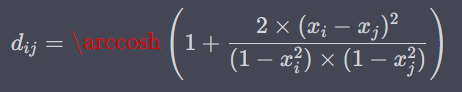

Create a new graph with movies as nodes and edges between them weighted by the inverse of the hyperbolic distance.

Let's start by calculating the hyperbolic distances between each pair of movies.



In [16]:
from scipy.spatial.distance import pdist, squareform

# Get the average rating for each movie
average_ratings = u_data.groupby('item_id')['rating'].mean()

# Create a matrix with average ratings for each pair of movies
average_ratings_matrix = np.zeros((len(average_ratings), len(average_ratings)))
for i, rating_i in enumerate(average_ratings):
    for j, rating_j in enumerate(average_ratings):
        average_ratings_matrix[i, j] = rating_i
        average_ratings_matrix[j, i] = rating_j

# Calculate the hyperbolic distance between each pair of movies
hyperbolic_distances = np.arccosh(1 + 2 * (average_ratings_matrix - average_ratings_matrix.T)**2 / ((1 - average_ratings_matrix**2) * (1 - average_ratings_matrix.T**2)))

# Replace infinities with large number
hyperbolic_distances[np.isinf(hyperbolic_distances)] = 1e6

# Create a graph with movies as nodes and hyperbolic distances as edge weights
G_hyperbolic = nx.Graph()
for i in range(len(average_ratings)):
    for j in range(i + 1, len(average_ratings)):
        G_hyperbolic.add_edge(i + 1, j + 1, weight=1 / hyperbolic_distances[i, j])

# Verify the graph creation
G_hyperbolic.number_of_nodes(), G_hyperbolic.number_of_edges()

C:\Users\jackh\AppData\Local\Temp\ipykernel_14196\1864435967.py:14: RuntimeWarning: divide by zero encountered in divide
  hyperbolic_distances = np.arccosh(1 + 2 * (average_ratings_matrix - average_ratings_matrix.T)**2 / ((1 - average_ratings_matrix**2) * (1 - average_ratings_matrix.T**2)))
C:\Users\jackh\AppData\Local\Temp\ipykernel_14196\1864435967.py:14: RuntimeWarning: invalid value encountered in divide
  hyperbolic_distances = np.arccosh(1 + 2 * (average_ratings_matrix - average_ratings_matrix.T)**2 / ((1 - average_ratings_matrix**2) * (1 - average_ratings_matrix.T**2)))
C:\Users\jackh\AppData\Local\Temp\ipykernel_14196\1864435967.py:14: RuntimeWarning: invalid value encountered in arccosh
  hyperbolic_distances = np.arccosh(1 + 2 * (average_ratings_matrix - average_ratings_matrix.T)**2 / ((1 - average_ratings_matrix**2) * (1 - average_ratings_matrix.T**2)))
C:\Users\jackh\AppData\Local\Temp\ipykernel_14196\1864435967.py:23: RuntimeWarning: divide by zero encountered in scalar d

(1682, 1413721)

The hyperbolic projection graph has been created with 1682 nodes (representing movies) and 1413721 edges (representing the hyperbolic distances between movies). Each edge has a weight corresponding to the inverse of the hyperbolic distance between two movies.

Next, we will proceed with the second step: applying the disparity filter algorithm to extract the network backbone from the projected graph. The disparity filter algorithm works by keeping only the significant edges that represent strong relationships between nodes, and removing edges that can be explained by the node's degree. Let's proceed with this step.​

Great! Let's proceed with Graph Sampling. In this approach, we will create a sample of the graph by randomly selecting a subset of nodes and their edges. This will reduce the size of the graph and the memory required for processing. Here are the steps we will follow:

Randomly sample a subset of nodes from the graph.
Create a subgraph with the sampled nodes and their edges.
Apply the disparity filter algorithm to extract the network backbone from the sampled graph.
Analyze the backboned graph vs. the original sampled graph.
Discover communities in the backboned graph.
Analyze the communities in terms of the metadata we have.

In [17]:
import random

def sample_graph(G, fraction=0.1):
    """
    Create a sample of a graph by randomly selecting a subset of nodes and their edges.
    
    Parameters:
    G (networkx.Graph): The graph to be sampled.
    fraction (float): The fraction of nodes to be included in the sample.
    
    Returns:
    networkx.Graph: The sampled graph.
    """
    # Randomly sample a subset of nodes
    nodes = list(G.nodes())
    sampled_nodes = random.sample(nodes, int(fraction * len(nodes)))
    
    # Create a subgraph with the sampled nodes and their edges
    sampled_graph = G.subgraph(sampled_nodes)
    
    return sampled_graph

# Create a sample of the graph
G_sampled = sample_graph(G_hyperbolic, fraction=0.1)

# Verify the size of the sampled graph
G_sampled.number_of_nodes(), G_sampled.number_of_edges()


(168, 14028)

The sampled graph has been created with 168 nodes and 14028 edges, which is a more manageable size for processing.

Next, we will proceed with the third step: applying the disparity filter algorithm to extract the network backbone from the sampled graph. Let's proceed with this step.